In [3]:
# For Leonie AAP EAP CEC - this was initially copied from exp5_extract
# see what we can find about those constructions

# todo
# - note that Aligned examples says "hhi" but the scores are actually surprisal
# - multithat examples (currently we are skipping them - only for the umap part, I think)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from collections import Counter
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

# change here to get the main paper vs appendix results
# will correct errors in the original dataset
# as well as one pipeline error
do_correct = False
# do_correct = True



# read in data

In [6]:
from rozlib.libs.common.data.utils_jsonl import read_from_jsonl
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import get_clean_exs
from paper.exp1_zhou.exp1_utils import align_mlm_results_with_input_data
from lib.exp_common.mlm_result_for_sentence import MLMResultForSentence
from data_config import Exp1Zhou

# from paper.exp1_zhou.exp5_utils import read_mlm_results
# from paper.exp1_zhou.exp5_utils import align_mlm_results_with_input_data, ResultWrapper

# NOTE: see exp5_extract for more notes about why this is all done here; mostly copied

# read in mlm RoBERTA scores outputs
# for the affinity matrix, we have only original HHI scores
mlm_results_hhi = read_from_jsonl(
    Exp1Zhou.zhou_affinities_hhi_euclid,
    MLMResultForSentence
)

print(len(mlm_results_hhi))
# all come in sets of 5 (we implemented their 5 different perturbations, but we only consider the unperturbed versions here)
print(len(mlm_results_hhi)/5)


# read in original data
all_exs = get_clean_exs(Exp1Zhou.zhou_original_xlsx,print_errors=True)
print(len(all_exs))


aligned_results_hhi = align_mlm_results_with_input_data(mlm_results_hhi, all_exs)

print(len(aligned_results_hhi)/5)
# 8 examples didn't run because of accents



1290
258.0
unhandled apostrophe [']
	Mendes was so dissatisfied with his first three days ' filming that he obtained permission from DreamWorks to reshoot the scenes . 

Unrecognized $ in In fact , I was so ecstatic that I invested in a 55 $ metal cutting blade . 

Unrecognized $ in I am so frustrated that a $ 500 purchase brought such short lived joy . 

No terminating quote! in She said , " I am super - excited to stay , and I am so honored that they asked me to stay . 

unhandled apostrophe [']
	Dow is so insistent that it closed in the 1870s and was converted into an Emigrants ' Home , Butt supports this with a date of 1879 and Anderson gives 1880 . 

Adj [overwhelmed] not found in sentence 
She said she was so "overwhelmed that she got the part and was looking forward to the challenge".


string index out of range 

No terminating quote! in Jean Edward Smith maintains , " The evidence is so overwhelming that during the Vicksburg campaign he occasionally fell off the wagon . 

unha

/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/proj/cxs_are_revealed/src/corpus_tools/zhou_cxs_so_difficult/corpus_leonie_eap_aap_cec.py:266: UserWarning: Multiple thats - check multithat to see; we are linking to first that
  warnings.warn("Multiple thats - check multithat to see; we are linking to first that")


In [11]:
from paper.exp1_zhou.exp1_utils import fix_labels

# copied mostly from exp5_extract
def find_in_aligned(id: int):
    res = [e for e in aligned_results_hhi if e.orig_example.id == id]
    print(len(res))
    assert len(res) == 5
    return res

# def correct():
#     """
#     Fix zhu you liang which somehow had the wrong value - manually fix
#     """
#     res = find_in_aligned(72)
#     one_res = res[0]
#     # note difference - we are using HHI not suprisal here
#     one_res.mlm_result.hhi_scores[one_res.orig_example.so_idx] = 0.99

if do_correct:
    fix_labels(all_exs)
    # this particular example did not show here (likely due to pipeline issue)
    # correct()


# Graph embeddings

In [12]:
#######
# graph embeddings!
########

# for the examples, we 
# - add the hhi scores along diagonal
# - get the indices we want to keep
# - truncate the score matrix
# -  plot with umap...

In [13]:
from rozlib.libs.library_ext_utils.utils_spacy import NLPWithCache

# from utils.utils_spacy import NLPWithCache

# use a spacy parser that has a cache
nlp = NLPWithCache()


Initialized NLP with model name en_core_web_trf and cache


In [14]:
# matrix helper methods

import torch
def normalize_affinity_matrix(matrix: torch.Tensor) -> torch.Tensor:
    """
    Normalize an affinity matrix using z-score normalization.

    Args:
        matrix (torch.Tensor): 2D tensor (affinity matrix with positive scores).

    Returns:
        torch.Tensor: Normalized affinity matrix with z-scores.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    # Compute mean and standard deviation of the matrix
    mean = torch.mean(matrix)
    std = torch.std(matrix)

    if std == 0:
        raise ValueError("Standard deviation is zero; normalization is undefined.")

    # Apply z-score normalization
    normalized_matrix = (matrix - mean) / std
    return normalized_matrix

def get_topk_indices(matrix: torch.Tensor, k: int):
    """
    Find the indices (i, j) of the top k values in a 2D tensor.

    Args:
        matrix (torch.Tensor): Input 2D tensor.
        k (int): Number of top values to find.

    Returns:
        list of tuples: List of (i, j) indices of the top k values in the matrix.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    if k > matrix.numel():
        raise ValueError(f"k ({k}) cannot be larger than the number of elements in the matrix ({matrix.numel()}).")

    # Flatten the matrix and get the top k values and their linear indices
    topk_values, topk_linear_indices = torch.topk(matrix.flatten(), k)

    # Convert linear indices to 2D indices
    topk_indices = [
        (torch.div(idx, matrix.size(1), rounding_mode='floor').item(), (idx % matrix.size(1)).item())
        for idx in topk_linear_indices
    ]

    return topk_indices

def extract_values_from_indices(matrix: torch.Tensor, indices: list):
    """
    Extract the values from a 2D tensor at the given list of (i, j) indices.

    Args:
        matrix (torch.Tensor): Input 2D tensor.
        indices (list of tuples): List of (i, j) indices to extract values from.

    Returns:
        torch.Tensor: A 1D tensor containing the extracted values.
    """
    if len(matrix.shape) != 2:
        raise ValueError("Input must be a 2D tensor.")

    # Separate the list of tuples into row and column indices
    row_indices, col_indices = zip(*indices)

    # Use advanced indexing to extract the values
    extracted_values = matrix[list(row_indices), list(col_indices)]

    return extracted_values

def topk_values_from_matrix(matrix: torch.Tensor, topk: int):
    topk_idcs = get_topk_indices(matrix, topk)
    return extract_values_from_indices(matrix, topk_idcs)


In [15]:
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import BaseExample
from rozlib.libs.library_ext_utils.utils_torch import torch_fill_diagonal
from lib.exp_common.mlm_result_for_sentence import MLMResultForSentence
from paper.exp1_zhou.exp1_utils import ResultWrapper, get_other_pos_idxs
import torch
# from utils.corpus.corpus_leonie_eap_aap_cec import BaseExample
# from paper.exp1_zhou.exp5_utils import get_other_pos_idxs


# get a list of graphs + their labels (for plotting with umap)
@dataclass
class GraphForEmbed:
    adjusted_matrix: torch.Tensor
    aligned_ex: ResultWrapper
    idxs_to_keep: List[int]


def process_score_matrix(
        mlm_res: MLMResultForSentence,
        idxs_to_keep: List[int],
        do_normalize=False,
        add_hhis=False
) -> torch.Tensor:
    """
    args: original score matrix, 
    should insert hhis along diagonal
    keep only appropriate indices
    
    potentially normalize
    """
    # todo: review uses of torch.Tensor instead of torch.tensor for initialization
    orig_score_matrix = torch.tensor(mlm_res.score_matrix_distribution)
    hhis = torch.tensor(mlm_res.hhi_scores)
    
    if do_normalize:
        orig_score_matrix = normalize_affinity_matrix(orig_score_matrix)
        torch_fill_diagonal(orig_score_matrix, torch.zeros_like(hhis))
    
    if add_hhis:
        # write hhis along diagonal
        # print("filling hhis on diagonal", orig_score_matrix.shape, hhis.shape)
        torch_fill_diagonal(orig_score_matrix, hhis)
    
    idxs = torch.tensor(idxs_to_keep)
    filtered_tensor = orig_score_matrix[idxs][:, idxs]
    
    return filtered_tensor

def get_canonical_idxs(
    base_ex: BaseExample,
    spacy_parsed_idxs: Tuple[int, int, int, int]
) -> List[int]:

    main_verb_idx, main_subj_idx, clause_verb_idx, clause_subj_idx = spacy_parsed_idxs
    return [
        main_subj_idx,
        main_verb_idx,
        base_ex.so_idx,
        base_ex.adj_idx,
        base_ex.that_idx,
        clause_subj_idx,
        clause_verb_idx
    ]


def get_aap_eap_for_plot(aligned):
    c = Counter()
    successful  = []
    for idx, aligned_res in enumerate(aligned):
        # only the unperturbed
        if idx % 5 != 0: continue
        c[aligned_res.orig_example.label.value] += 1
        # print(idx)

        c['all'] += 1
        # todo: we could better handle multithat (for now we skip them)
        # in our original code we could look for clausal complement attachment (to the adj we care about)
        # we might want to do this when add multiple that clauses
        if aligned_res.has_error:
            c['err'] += 1
            #todo(low) consider printing
            # shoudl not happen for any of the ones we are looknig at
            continue

        if aligned_res.orig_example.multi_that:
            c['multithat'] += 1
            # todo(low): consider printing here
            continue

        # get the idxs using spacy
        try:
            print(aligned_res.orig_example.sentence_punct_fixed)
            other_idxs = get_other_pos_idxs(nlp, aligned_res.orig_example, do_print=True)
        except Exception as e:
            c['pos_spacy'] += 1
            # todo: why is this; i thought we dealt with all of these
            print(f"unable to find expected POS with spacy")
            continue

        canonical_idxs = get_canonical_idxs(aligned_res.orig_example, other_idxs)

        # we skip any where a word we need to check is multitokenized (since the aff array is not populated)
        overlapping_idxs = set(canonical_idxs).intersection(set(aligned_res.mlm_result.multi_tok_indices))
        if len(overlapping_idxs) > 0:
            c['multitoken'] += 1
            continue

        # todo: should we check aligned across mlm and original input?
        # mlm_result_words = aligned_res.mlm_result.sentence.split(" ")

        processed_scores = process_score_matrix(
            aligned_res.mlm_result,
            canonical_idxs,
            # do_normalize=True,
            add_hhis=True
        )
        c['successful'] += 1
        successful.append(GraphForEmbed(
            processed_scores,
            aligned_res,
            canonical_idxs
        ))
    print(c)
    return successful

data_for_plot = get_aap_eap_for_plot(aligned_results_hhi)

    

One man was so afraid that he camped in the middle of his flock, hoping to evade patrolling cowboys.
man was so afraid that he camped
He was so afraid that rival loyalist inmates wished to kill him inside the prison.
He was so afraid that inmates wished
He was so amazed that he forgot to thank me.
He was so amazed that he forgot
Her uncle was so angry that he sent her to live in a Lutheran orphanage, where she spent the rest of her childhood.
uncle was so angry that he sent
Luka is so angry that she cheated on him and put their son's life in danger.
Luka is so angry that she cheated
Northern Liang's duke Juqu Mengxun became so apprehensive that he offered to yield his territory and relocate his entire army into Later Qin proper.


/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


duke became so apprehensive that he offered
Seven is so apprehensive that the Ledosians scanned her deflector modifications and may eventually construct their own device to disable the barrier.
Seven is so apprehensive that Ledosians scanned
It's his lucky quarter and Pop feels so bad that Lucky lost it.
Pop feels so bad that Lucky lost
Sundarapandian feels so bad that all his friends betrayed him.
Sundarapandian feels so bad that friends betrayed
The family quarrel became so bitter that the Duke went abroad for a time with his new wife.
quarrel became so bitter that Duke went
In the end, Fisk was so bitter that none of his friends and old political allies intervened to help his original case.
Fisk was so bitter that none intervened
I was so certain of the Cuisinart brand name that I threw out the boxes and other packaging and the damned thing didn't work.
I was so certain that I threw
When he was 12, he was so certain that he desired to be a music producer.
he was so certain that he d

In [16]:

def print_counts():
    c = Counter()
    for s in data_for_plot:
        c[s.aligned_ex.orig_example.label.value] += 1
    print(c)
print_counts()

Counter({3: 60, 4: 29, 1: 26, 2: 14})


In [17]:
from corpus_tools.zhou_cxs_so_difficult.corpus_leonie_eap_aap_cec import CxType
from rozlib.libs.statistics.utils_sklearn import fit_svm
# from utils.utils_sklearn import fit_svm
# from utils.utils_latex_matplot import save_fig
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List, Optional

import umap


# todo: move to plots
def plot_2d_tensors_umap(
        objects: List[GraphForEmbed],
        metric: str,
        nneighbors: int,
        min_dist: float,
        title: str = None,
        aggregate =False,
        label_points = False,
        random_state=4,
        ax: Optional = None,
        add_ax_titles=False,
        figsize=(5,5),
        s=50,
        savefigname: str = None,
        add_svm = False,
        add_legend = False,
        add_markers = True
):
    """
    Embeds and plots a collection of 2D torch tensors using UMAP.

    Each tensor is flattened row-wise to create a 1D vector before embedding.
    The dots in the UMAP plot are colored based on the labels of the objects.

    Parameters:
    - objects: List of objects with the following properties:
        - `matrix`: 2D torch.Tensor to be embedded.
        - `label`: Label for coloring the corresponding point in the UMAP plot.
    """
    # Flatten each 2D tensor row-wise to create 1D vectors
    # data = [obj.adjusted_matrix.flatten().numpy() for obj in objects]

    data = [extract_values_from_indices(obj.adjusted_matrix, _topk_idcs).flatten().numpy() for obj in objects]
    # data = [compute_normalized_laplacian(obj.adjusted_matrix).flatten().numpy() for obj in objects]
    # data = [compute_column_dot_products(obj.adjusted_matrix).flatten().numpy() for obj in objects]
    labels = [obj.aligned_ex.orig_example.label.value for obj in objects]

    def label_map(l_in: int):
        if l_in in [1,2]:
            return 1
        else:
            return 2
    if aggregate:
        labels = [label_map(l) for l in labels]

    # Convert to numpy array for UMAP
    data = np.array(data)
    labels = np.array(labels)

    # Apply UMAP for dimensionality reduction
    reducer = umap.UMAP(n_neighbors=nneighbors, min_dist=min_dist, metric=metric, random_state=random_state)
    embedding = reducer.fit_transform(data)

    # Generate a discrete colormap
    unique_labels = np.unique(labels)
    # cmap = ListedColormap(plt.cm.tab10.colors[:len(unique_labels)])
    # swap first two colors to match histogram
    cmap = ListedColormap(plt.cm.Dark2.colors[:len(unique_labels)][::-1])

    # Plot the UMAP embedding
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    marker_labels = [i-1 for i in labels]
    if add_markers:
        markers = ['o', '^']
        marker_list = np.choose(marker_labels, markers)
    else:
        markers = ['o']
        marker_list = np.array(['o'] * len(labels))

    # plot based on marker
    for i, marker in enumerate(markers):
        mask = marker_list == marker
        scatter = ax.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            # note that just using c and cmap won't work bc each group gets the same color
            c=cmap(i),
            # c=labels[mask],
            # cmap=cmap,
            s=s,
            alpha=0.7,
            # edgecolor="k",
            marker=marker
        )
    # scatter = ax.scatter(
    #     embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=s, alpha=0.7, edgecolor="k",
    # )
    if add_svm:
        xx, yy, Z = fit_svm(embedding, labels)
        plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black", linestyles="dashed")  # Decision boundary

    if add_legend:
        ax.legend(
            handles=scatter.legend_elements()[0],
            labels=[CxType.pretty_name_for_value(label) for label in unique_labels],
            loc="lower left",
            frameon=False,
            handletextpad=0,
            borderpad=0,
            labelspacing=0,
            # bbox_to_anchor=(0,1)
            # title="Labels",
        )

    # Add labels to each point
    if label_points:
        for i, obj in enumerate(objects):
            if not obj.aligned_ex.orig_example.id in [1, 320, 270, 95, 286]: continue
            ax.annotate(
                # r"\textbf{" + str(obj.aligned_ex.orig_example.id) + "}",
                obj.aligned_ex.orig_example.id,
                        (embedding[i, 0], embedding[i, 1]),
                        textcoords="offset points",
                        xytext=(3, 3),
                        ha='center',
                        fontsize=12
                        )

    # ax.add_artist(legend)
    # plt.title("UMAP: EAP vs AAP", fontsize=14)
    if title:
        ax.set_title(title, fontsize=14)
    if add_ax_titles:
        ax.set_xlabel("Embedding dimension 1")
        ax.set_ylabel("Embedding dimension 2")
    # ax.grid(True, which="both", alpha=0.3, linewidth=0.5)
    ax.grid(False, which="both")
    ax.set_xticks([])
    ax.set_yticks([])

    # todo
    # if savefigname and fig:
    #     save_fig(fig, f"{savefigname}")
    # ax.show()


In [18]:
def aap_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value == 1:
        return True
    return False

def eap_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value == 2:
        return True
    return False

def non_causal_filter(g: GraphForEmbed):
    if g.aligned_ex.orig_example.label.value < 3:
        return True
    else:
        return False

non_causal_exs: List[GraphForEmbed] = list(filter(non_causal_filter, data_for_plot))

aaps = list(filter(aap_filter, data_for_plot))
eaps = list(filter(eap_filter, data_for_plot))

aap_matrices = list(map(lambda x: x.adjusted_matrix, aaps))
eap_matrices = list(map(lambda x: x.adjusted_matrix, eaps))

def matrix_avg(matrix_list):
    return sum(matrix_list)/len(matrix_list)

aap_avg = matrix_avg(aap_matrices)
eap_avg = matrix_avg(eap_matrices)




/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/rozlib/libs/plotting/utils_latex_matplot.py:46: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_6800/4026665162.py:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


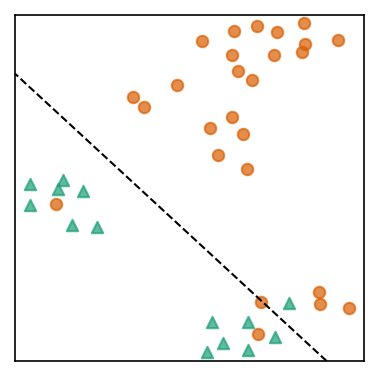

In [20]:

from rozlib.libs.plotting.utils_latex_matplot import config_matplot_for_latex
config_matplot_for_latex(14)
_topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), 5)
# run do_correct first
plot_2d_tensors_umap(non_causal_exs, 'euclidean', 10, 0.1, aggregate=False,
                     random_state=6,
                     # title=f"dims: {d}",
                     label_points=False,
                     ax=None,
                     add_ax_titles=False,
                     figsize=(3,3),
                     s=30,
                     savefigname=f"eap_aap_umap_{do_correct}.pdf",
                     add_svm=True,
                     add_markers=True
                     )


/Users/jsrozner/docs_local/research/projects/research_constructions/constructions_repo/rozlib/libs/plotting/utils_latex_matplot.py:46: UserWarning: /Library/TeX/textbin will be added to path
  warnings.warn(f"/Library/TeX/textbin will be added to path")
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/58/nkm5hbs97tz3vc0x5l5zl4w40000gn/T/ipykernel_6800/4026665162.py:89: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/2024_coelm/lib/python3.12/site-packages/umap/umap_.py:1952

NameError: name 'save_fig' is not defined

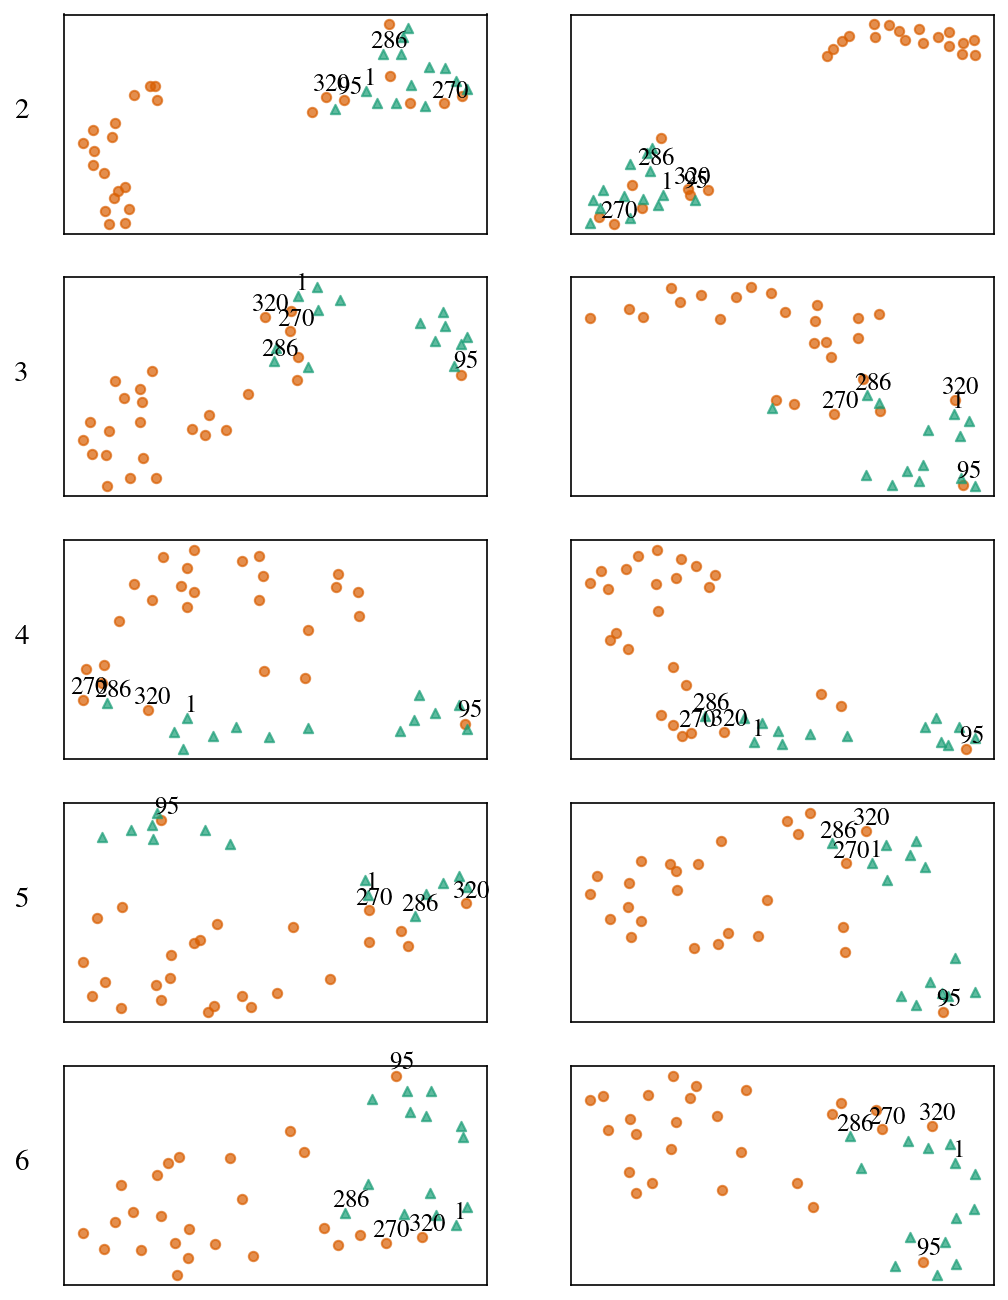

In [21]:


# 4 with random seed 2
# _topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), 20)
# print(_topk_idcs)

dims = list(range(2,7))
plots = list(range(0,2))
fig, axes = plt.subplots(len(dims), len(plots), figsize=(8, 11))
i = 0

# make reproducible
rng = np.random.default_rng(42)
# higher dpi looks bad
config_matplot_for_latex(14, legend_font_change=2, dpi=100)
for i, d in enumerate(dims):
    for j,p in enumerate(plots):
        _topk_idcs = get_topk_indices(abs(aap_avg-eap_avg), d)
        ax = axes[i, j]
        plot_2d_tensors_umap(non_causal_exs, 'euclidean', 10, 0.1, aggregate=False,
                             random_state=rng.integers(0, 1000000),
                             # title=f"dims: {d}",
                             label_points=True,
                             ax=ax,
                             figsize=(8/len(plots),11/len(dims)),
                             s=20
                             )
        # todo not sure why we needed
        ax.grid = False
        for spine in ax.spines.values():
            spine.set_color('black')
for d, ax in zip(dims, axes[:,0]):
    ax.set_ylabel(d, rotation=0, labelpad=20)
# todo
# save_fig(fig, f"umap_appendix_multi_{do_correct}.pdf")
# plot_2d_tensors_umap(data_for_plot, 'euclidean', 10, 0.1, aggregate=True)
